<a href="https://colab.research.google.com/github/UranMai/Binding_affinity/blob/master/Untitled25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Install rdkit library for molecules
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

In [0]:
import pandas as pd
data = pd.read_csv("compound_10000.csv")
data = data[1:10000]
data = data[data.columns[1:4]]

In [44]:
data['mol'] = data['smi'].apply(lambda x: Chem.MolFromSmiles(x))
data = data.dropna()
data = data.reset_index(drop=True)
data.head()

,smi,Score,mol
0,O=C1[C@@H](N2CCc3cccc(F)c32)CCN1CC(F)(F)F,-30.615744,<rdkit.Chem.rdchem.Mol object at 0x7fd9078a8c60>
1,CSCc1cc(C(=O)N2CCc3[nH]ncc3C2)ccc1F,-25.646399,<rdkit.Chem.rdchem.Mol object at 0x7fd9078a8b70>
2,CC(=O)Nc1ccc(NC(=O)CSc2ccc(F)cc2)cc1,-29.502308,<rdkit.Chem.rdchem.Mol object at 0x7fd9078a8940>
3,CC1(C)C[C@H]1C(=O)NC1CCCCCCC1,-20.051771,<rdkit.Chem.rdchem.Mol object at 0x7fd745491df0>
4,CC(=O)c1ccc(NC(=O)COC(=O)Cc2ccsc2)cc1,-21.931228,<rdkit.Chem.rdchem.Mol object at 0x7fd745456210>


In [0]:
#data['bit_vect'] = data['mol'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x,2,1024))

# tanimoto_similarity 
# 1 - is the equivalent
# 0 - is different

**calculate similarities and convert to distances by substacting from 1**


fps[:i] - first i-1 elements 

**Butina clustering** with distthreshold (<0.83) divides to clusters if less then threshold

If threshold less (like 0.4, default is 0.7) than the division more precise



Butina.ClusterData(data, nPts, distThresh, isDistData=False, distFunc=<function EuclideanDist>, reordering=False)



*   clusters the data points passed in and returns the list of clusters
*   






In [0]:
from rdkit.ML.Cluster import Butina

# Returns a Morgan fingerprint for a molecules (data of molecules) as a bit vector of shape 1024
fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in data['mol']] 


def Cluster_Fps(fps, cutoff=0.2):
  dists = []
  len_fps = len(fps)
  for i in range(1, len_fps):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i]) #Tanimoto similarities(float values) between fps
    dists.extend([1-x for x in sims])

  cs = Butina.ClusterData(dists, len_fps, cutoff, isDistData = True)
  return cs


cluster = Cluster_Fps(fps, cutoff=0.4)

In [0]:
def Cluster_histogram(fps):
    dists=[]
    for i in range(1, len(fps)):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        dists.extend([1-x for x in sims])
    return dists

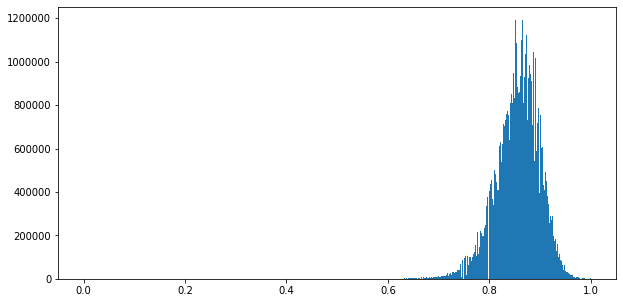

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(Cluster_histogram(fps), bins=500)
plt.show()

In [0]:
#fps = [AllChem.GetMorganFingerprintAsBitVect(x,2,1024) for x in data['mol']]
#Fingeprints circular
#fps1 = [AllChem.GetMorganFingerprintAsBitVect(x,2,2048) for x in data['mol']]
#return ExplicitBitVector

#fps2 = [AllChem.GetMorganFingerprintAsBitVect(x,3,1024) for x in data['mol']] #more ones(1) when radius increases, more details


In [0]:
#clustering with cuoff=0.4
#print(len(cluster))
#print(cluster)

# rr

In [50]:
''' Different molecules
ml1 = data['mol'][21]
ml2 = data['mol'][20]
ml3 = data['mol'][19]
ml4 = data['mol'][24]

mols = (ml1, ml2, ml3, ml4)
Draw.MolsToGridImage(mols)
'''

" Different molecules\nml1 = data['mol'][21]\nml2 = data['mol'][20]\nml3 = data['mol'][19]\nml4 = data['mol'][24]\n\nmols = (ml1, ml2, ml3, ml4)\nDraw.MolsToGridImage(mols)\n"

# New Sectionrr

In [0]:
'''
  make_data function create train/valid/test dataframes

  input: cluster after Clustering represent as tuple of tuples of elements
         data - our Dataframe of smiles and scores
  output: dataframes

'''
def make_data(cluster, data):
  datum = data.copy()
  data_list = list(sum(cluster, ()))
  length_train = int(len(data_list)*.8)
  length_valid = int(len(data_list)*.9)
  #length_test = int(len(data_list)*.1)
  #length_test = len(data) - length_train - length_valid

  data_train = data_list[:length_train]
  data_valid = data_list[length_train:length_valid]
  data_test = data_list[length_valid:]

  dframe_train = pd.DataFrame()
  dframe_valid = pd.DataFrame() #one parameter in it, column=['smi','Score']
  dframe_test  = pd.DataFrame()

  
  for id, value in enumerate(data_train):
    dframe_train = dframe_train.append(datum.iloc[[value], [0,1,2]], ignore_index=True)

  for value in data_valid:
    dframe_valid = dframe_valid.append(datum.iloc[[value], [0,1,2]], ignore_index=True)

  for value in data_test:
    dframe_test = dframe_test.append(datum.iloc[[value], [0,1,2]], ignore_index=True)
  
  return dframe_train, dframe_valid, dframe_test

In [52]:
'''
length = int(len(cluster) *0.8)
print(length)

ids = []
for i in range(length):
  ids.append(cluster[i])
print(ids)
'''

'''
ml1 = data['mol'][9611]
ml2 = data['mol'][7461]
mols = (ml1, ml2)
Draw.MolsToGridImage(mols)
'''

"\nml1 = data['mol'][9611]\nml2 = data['mol'][7461]\nmols = (ml1, ml2)\nDraw.MolsToGridImage(mols)\n"

In [0]:
# split_data = make_data(cluster=cluster, data=data)
# split_data[0] - train
# split_data[1] - valid
# split_data[2] - test

# Scaffold splitting


In [59]:
data

,smi,Score,mol
0,O=C1[C@@H](N2CCc3cccc(F)c32)CCN1CC(F)(F)F,-30.615744,<rdkit.Chem.rdchem.Mol object at 0x7fd9078a8c60>
1,CSCc1cc(C(=O)N2CCc3[nH]ncc3C2)ccc1F,-25.646399,<rdkit.Chem.rdchem.Mol object at 0x7fd9078a8b70>
2,CC(=O)Nc1ccc(NC(=O)CSc2ccc(F)cc2)cc1,-29.502308,<rdkit.Chem.rdchem.Mol object at 0x7fd9078a8940>
3,CC1(C)C[C@H]1C(=O)NC1CCCCCCC1,-20.051771,<rdkit.Chem.rdchem.Mol object at 0x7fd745491df0>
4,CC(=O)c1ccc(NC(=O)COC(=O)Cc2ccsc2)cc1,-21.931228,<rdkit.Chem.rdchem.Mol object at 0x7fd745456210>
...,...,...,...
9962,O=C(O)[C@H]1Cc2ccccc2CN1C(=O)Cc1coc(-c2ccccc2)n1,-33.128922,<rdkit.Chem.rdchem.Mol object at 0x7fd7452d9990>
9963,Cc1cnc(C(=O)N[C@@H](CC(=O)O)c2ccccc2Cl)cn1,-35.025170,<rdkit.Chem.rdchem.Mol object at 0x7fd7452d99e0>
9964,Cc1ccccc1[C@H]1CN(Cc2ccc(Cl)c(F)c2)[C@H](CO)[C...,-28.882052,<rdkit.Chem.rdchem.Mol object at 0x7fd7452d9a30>
9965,Cc1nccnc1N1C[C@H](c2cccc(F)c2F)[C@@H]2[C@H]1C1...,-25.325461,<rdkit.Chem.rdchem.Mol object at 0x7fd7452d9a80>


In [0]:
#Compute Bemis_Murcko scaffolds that contain ring systems with linker atoms
from rdkit.Chem.Scaffolds import MurckoScaffold
''' 
  input: smiles string
  return: scaffold structure of molecule
'''

def generate_scaffold(mol):
    mol = Chem.MolFromSmiles(mol)
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)
    return scaffold

def scaffold_to_smiles(mols, use_indices: bool = False):
    scaffolds = list()
    for i, mol in tqdm(enumerate(mols), total=len(mols)):
        scaffold = generate_scaffold(mol)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(mol)

    return scaffolds


In [0]:
log_every_n = 100
data_len = len(data)
scaffolds = {}
for ind, smiles in enumerate(data.smi):
  scaffold = generate_scaffold(smiles)
  if scaffold not in scaffolds:
    scaffolds[scaffold] = [ind]
  else:
    scaffolds[scaffold].append(ind)




scaffolds = {key: sorted(value) for key, value in scaffolds.items()}

In [0]:
scaffold_sets = [
        scaffold_set
        for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]

In [0]:
import numpy as np
frac_train=.8
frac_valid=.1
frac_test=.1
np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)

In [0]:
def train_valid_test_split(data,
          frac_train=.8,
          frac_valid=.1,
          frac_test=.1):
    """
        Splits internal compounds into train/validation/test by scaffold.
    """
    
    scaffolds = {}
    for ind, smiles in enumerate(data.smi):
      scaffold = generate_scaffold(smiles)
      if scaffold not in scaffolds:
        scaffolds[scaffold] = [ind]
      else:
        scaffolds[scaffold].append(ind)

    # Sort from largest to smallest scaffold sets (with more same scaffolds, the largest one is 51 elements)
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [
        scaffold_set
        for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]

    train_cutoff = frac_train * len(data)
    valid_cutoff = (frac_train + frac_valid) * len(data)
    train_inds, valid_inds, test_inds = [], [], []
   
    for scaffold_set in scaffold_sets:
      if len(train_inds) + len(scaffold_set) > train_cutoff:
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
          test_inds += scaffold_set
        else:
          valid_inds += scaffold_set
      else:
        train_inds += scaffold_set

    return train_inds, valid_inds, test_inds

In [0]:
train = train_valid_test_split(data)[0]
valid = train_valid_test_split(data)[1]
test = train_valid_test_split(data)[2]

In [154]:
train


[970,
 1016,
 1405,
 1419,
 1457,
 1804,
 1950,
 2033,
 2572,
 2687,
 2713,
 2891,
 2932,
 2963,
 3153,
 3239,
 3376,
 3431,
 3562,
 3835,
 3884,
 4436,
 4449,
 4465,
 4757,
 4859,
 4863,
 4909,
 5565,
 5585,
 5704,
 5803,
 6003,
 6561,
 6800,
 6917,
 7046,
 7077,
 8085,
 8222,
 8306,
 8391,
 8508,
 8680,
 8997,
 9312,
 9615,
 9619,
 9720,
 9740,
 9808,
 61,
 172,
 181,
 193,
 240,
 477,
 1229,
 1306,
 1454,
 1602,
 1937,
 2022,
 2126,
 2528,
 2664,
 2681,
 2881,
 2890,
 2940,
 2994,
 3079,
 3321,
 3496,
 3572,
 3910,
 4127,
 4290,
 4736,
 4781,
 4979,
 5542,
 5681,
 5833,
 6174,
 6197,
 6244,
 6375,
 6825,
 6847,
 7251,
 7332,
 7489,
 7669,
 7983,
 8070,
 8829,
 8869,
 8904,
 9106,
 9616,
 94,
 266,
 707,
 1066,
 1242,
 1309,
 1538,
 1608,
 2243,
 2325,
 2513,
 2569,
 3274,
 3585,
 4065,
 4526,
 4939,
 5045,
 5229,
 5699,
 5963,
 7504,
 7725,
 8404,
 8767,
 9099,
 9110,
 9394,
 9549,
 9721,
 1160,
 1346,
 1633,
 2899,
 3185,
 3583,
 3731,
 4378,
 4478,
 4703,
 4771,
 5062,
 5471,
 593

In [0]:
def Splitting_DataFrame(data,
                        train_inds,
                        valid_inds,
                        test_inds):
  
  datum = data.copy()
  #data_list = list(sum(cluster, ()))
  #length_train = int(len(data_list)*.8)
  #length_valid = int(len(data_list)*.9)
  #length_test = int(len(data_list)*.1)
  #length_test = len(data) - length_train - length_valid

  #data_train = data_list[:length_train]
  #data_valid = data_list[length_train:length_valid]
  #data_test = data_list[length_valid:]

  dframe_train = pd.DataFrame()
  dframe_valid = pd.DataFrame() #one parameter in it, column=['smi','Score']
  dframe_test  = pd.DataFrame()

  
  for id, value in enumerate(train_inds):
    dframe_train = dframe_train.append(datum.iloc[[value], [0,1,2]], ignore_index=True)

  for value in valid_inds:
    dframe_valid = dframe_valid.append(datum.iloc[[value], [0,1,2]], ignore_index=True)

  for value in test_inds:
    dframe_test = dframe_test.append(datum.iloc[[value], [0,1,2]], ignore_index=True)
  
  return dframe_train, dframe_valid, dframe_test

In [161]:
Splitting_DataFrame(data, train, valid, test)

(                                                    smi  ...                                               mol
 0                       COc1ccc(N)cc1NC(=O)c1cccc(Cl)c1  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd745258c10>
 1                  COc1c(Cl)cc(C(=O)O)cc1NC(=O)c1ccccc1  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd745257ad0>
 2     Cc1cc(C)c(NC(=O)c2ccc(Cl)c(S(=O)(=O)N(C)C)c2)c...  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd74525f760>
 3                COc1ccc(NC(=O)c2ccc(CNC(C)(C)C)cc2)cc1  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd74525fbc0>
 4     CCS(=O)(=O)Nc1ccc(C(=O)Nc2cccc([N+](=O)[O-])c2...  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd745262800>
 ...                                                 ...  ...                                               ...
 7968                       Cc1c(I)c(-c2ccncc2)nn1CC(C)C  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd745278030>
 7969        Cc1cc(Br)ccc1Nc1cc(C2CC2)[nH]c(=NCC(=O)O)n1  ...  <rdkit.Chem.rdchem.Mol object at 0x7fd745